## **Librerías**

In [1]:
import pandas as pd
import numpy as np

import polars as pl

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

In [79]:
import plotly.express as px

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, classification_report, confusion_matrix

In [3]:
import sys
sys.path.append('./')
sys.path.append('../')

In [4]:
from utils.functions_eda import resumen_dataframe

## **Datos**

In [5]:
df = pl.read_csv('../Data/Raw/Titanic_Spaceship.csv')

In [6]:
df.sample()

PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Grouped,Deck,Side,Has_expenses,Is_Embryo
str,str,bool,str,str,f64,bool,f64,f64,f64,f64,f64,bool,bool,str,str,bool,bool
"""3903_01""","""Earth""",false,"""G/636/P""","""55 Cancri e""",2.0,false,0.0,0.0,0.0,0.0,0.0,false,true,"""G""","""P""",false,false


### **Limpieza**

In [7]:
resumen_dataframe(df.to_pandas())

,Variable,Tipo_Dato,Registros_Esperados,Valores_Unicos,Valores_Nulos,%Valores_Nulos
0,PassengerId,object,8693,8693,0,0.0
1,HomePlanet,object,8693,3,0,0.0
2,CryoSleep,bool,8693,2,0,0.0
3,Cabin,object,8693,6560,0,0.0
4,Destination,object,8693,3,0,0.0
5,Age,float64,8693,80,0,0.0
6,VIP,bool,8693,2,0,0.0
7,RoomService,float64,8693,1274,0,0.0
8,FoodCourt,float64,8693,1508,0,0.0
9,ShoppingMall,float64,8693,1116,0,0.0


In [32]:
df = df.to_dummies(
    columns=['HomePlanet', 'Destination', 'Deck', 'Side'], 
    drop_first=True
)

In [39]:
df_model = df.select(
    # Categorical variables
    pl.col([
        'HomePlanet_Earth', 'HomePlanet_Mars', 'Side_S', 'Deck_A', 'Deck_C', 'Deck_D', 
        'Deck_E', 'Deck_F', 'Deck_G', 'Deck_T'
    ]),
    pl.col('Destination_55 Cancri e').alias('Destination_55'),
    pl.col('Destination_PSO J318.5-22').alias('Destination_PSO'),
    
    # Boolean variables
    pl.col(['CryoSleep', 'VIP', 'Transported', 'Grouped', 'Has_expenses', 'Is_Embryo']).cast(pl.Int8),

    # Numeric variables 
    pl.col(['Age']),
    pl.col(['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']),
)

In [47]:
X = df_model.drop('Transported').to_pandas()
y = df_model['Transported'].to_pandas()

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13)

## **Modelo**

In [50]:
model = LogisticRegression(
    penalty='l2', 
    C=0.1, 
    solver='liblinear', 
    max_iter=1000, 
    random_state=13
)

In [51]:
model.fit(X_train, y_train)

LogisticRegression(C=0.1, max_iter=1000, random_state=13, solver='liblinear')

In [52]:
y_pred = model.predict(X_test)

<Axes: >

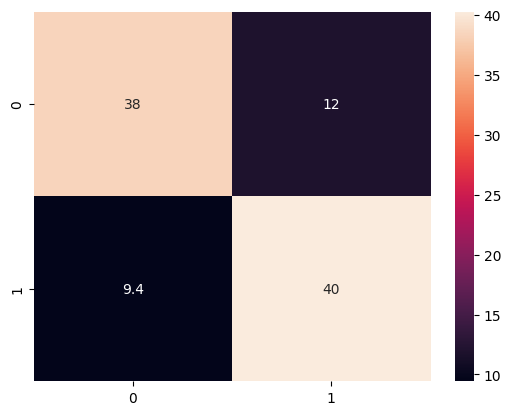

In [60]:
sns.heatmap(
    confusion_matrix(y_pred=y_pred, y_true=y_test)/len(y_test) * 100,
    annot=True
)

In [61]:
print(classification_report(y_pred=y_pred, y_true=y_test))

              precision    recall  f1-score   support

           0       0.80      0.76      0.78      1312
           1       0.77      0.81      0.79      1296

    accuracy                           0.79      2608
   macro avg       0.79      0.79      0.79      2608
weighted avg       0.79      0.79      0.79      2608



In [69]:
logit_roc_auc = roc_auc_score(y_test, y_pred)
logit_roc_auc

0.7865712511291779

In [70]:
fpr, tpr, thesholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])

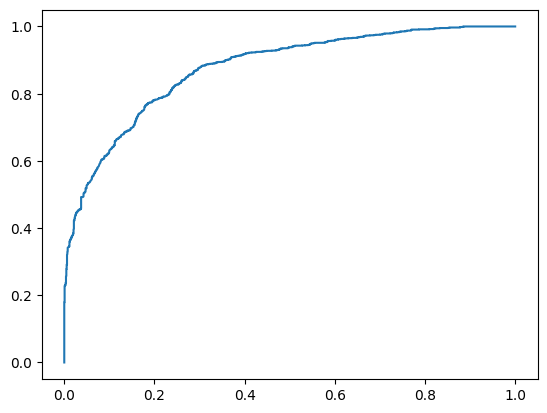

In [78]:
plt.plot(
    fpr, tpr
)

plt.show()

In [115]:
fig = px.line(
    x = fpr,
    y = tpr,
    width=600
)

fig.add_shape(
    type = 'line',
    x0 = 0, x1 = 1,
    y0 = 0, y1 = 1,
    line = dict(
        dash = 'dash'
    )
)

fig.update_layout(
    title = dict(
        text = 'ROC Curve',
        font = dict(
            size = 18,
            weight = 'bold',
            color = 'black'
        )
    ),

    xaxis = dict(
        title = 'False Positive Rate (FPR)',
        showline = True,
        linecolor = 'black',
        range = [0, 1],
        ticks = 'outside',
        titlefont = dict(color = 'black', weight = 'bold', size = 12)
    ),
    yaxis = dict(
        title = 'True Positive Rate (TPR)',
        showline = True,
        linecolor = 'black',
        range = [0, 1],
        ticks = 'outside',
        titlefont = dict(color = 'black', weight = 'bold', size = 12)
    ),
    paper_bgcolor = 'white',
    plot_bgcolor = 'white'
)

fig.show()